# Preparing the data for Base Line Evaluation

## Importing the required Packages

In [1]:
#Packages for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
from datetime import datetime
from scipy import stats
from scipy.sparse import csc_matrix

#Packages for splitting data
from sklearn import base
from sklearn.model_selection import KFold

#Packages for controlling figure size
from IPython.core.pylabtools import figsize


In [2]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

## Importing Clean Data from the CSV file

In [3]:
#Setting the file path
train_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\train_cleaned.csv'
test_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\test_cleaned.csv'

#Reading the csv file to pandas dataframe
train_clean = pd.read_csv(train_file)
test_clean = pd.read_csv(test_file)

In [4]:
#Check shape of the dataset and number of columns
print("Train Shape", train_clean.shape)
print("Test Shape", test_clean.shape)

Train Shape (7377418, 37)
Test Shape (2556790, 37)


In [5]:
train_clean.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,count_artist_played,duration,registration_year,expiration_year,registration_month,expiration_month,registration_day,expiration_day,age_of_song,song_type
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,1140,2103.0,2012,2017,1,10,2,5,1,long
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,composer_missing,...,303616,2301.0,2011,2017,5,9,25,11,18,long
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,289,2301.0,2011,2017,5,9,25,11,11,long
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,1,2301.0,2011,2017,5,9,25,11,7,long
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,427,2103.0,2012,2017,1,10,2,5,1,long


## Target Encoding

### Features with more than 25 categories will be target encoded. Rest will one-hot encoding

In [6]:
# Defining class to target encoding of training data
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,smoothing=5,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        self.smoothing = smoothing

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        
        
        # Spliting the data into kfolds
        kf = KFold(n_splits = self.n_fold)

        # Naming the column
        col_mean_name = self.colnames + '_' + 'encoded'
        X[col_mean_name] = np.nan

        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            #print(tr_ind,val_ind) 
            
            # creating target values
            enc = X_tr.groupby(self.colnames)[self.targetName].agg(['count', 'mean'])
            counts = enc['count']
            means = enc['mean']
            
            # Applying smoothing to counter low frequency samples
            smooth = (counts * means + self.smoothing * mean_of_target) / (counts + self.smoothing)

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(smooth)

            # If variable not found then fill with global mean
            X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        # Droping the original column
        if self.discardOriginal_col:
            X = X.drop(self.colnames, axis=1)
            

        return X

In [7]:
# Target encoding class for Test Data Set
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):


        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})

        return X

In [8]:
target_encod_col = ['genre_ids', 'composer', 'artist_name', 'lyricist', 'isrc_country']
train_enc = train_clean
for col in target_encod_col:
    targetc = KFoldTargetEncoderTrain(col,'target',n_fold=5, discardOriginal_col=True )
    train_enc = targetc.fit_transform(train_enc)

Correlation between the new feature, genre_ids_encoded and, target is -0.02021206771320489.
Correlation between the new feature, composer_encoded and, target is 0.10282564772309626.
Correlation between the new feature, artist_name_encoded and, target is 0.10598778158865219.
Correlation between the new feature, lyricist_encoded and, target is 0.07321287042731096.
Correlation between the new feature, isrc_country_encoded and, target is -0.04529379547490228.


In [9]:
train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 37 columns):
msno                        object
song_id                     object
source_system_tab           object
source_screen_name          object
source_type                 object
target                      int64
song_length                 float64
language                    float64
city                        int64
bd                          int64
gender                      object
registered_via              int64
lyricist_count              int64
artist_count                int64
composer_count              int64
genre_count                 int64
isrc_year                   int64
song_freq                   float64
artist_freq                 float64
composer_artist_lyricist    int64
composer_artist             int64
count_song_played           int64
count_artist_played         int64
duration                    float64
registration_year           int64
expiration_year      

#### Resizing the data for efficient use of memory

In [10]:
# Memory used before resize
mem = train_enc.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   2082.553680419922 MB


In [11]:
drop_col = ['msno', 'song_id', 'registration_day', 'expiration_day', 
            'registration_month', 'composer_artist_lyricist', 'composer_artist', 'gender']
train_enc = train_enc.drop(drop_col,axis=1)

# Selecting string columns
cat_names = list(train_enc.select_dtypes(include='object').columns)
#cat_names_2 = ['language','city','registered_via', 'isrc_year']
#cat_names.extend(cat_names_2)

#Converting to categories
train_enc[cat_names] = train_enc[cat_names].astype('category')

int_names = list(train_enc.select_dtypes(include='int64').columns)
int_names.remove('count_artist_played')
int_names.remove('count_song_played')
#print(int_names)
train_enc[int_names] = train_enc[int_names].astype('int16')
train_enc[['count_artist_played', 'count_song_played']] = train_enc[['count_artist_played', 'count_song_played']].astype('int32')

int_8_col = ['target']
train_enc[int_8_col] = train_enc[int_8_col].astype('int8')

float_names = list(train_enc.select_dtypes(include='float64').columns)
float_names.remove('song_length')
train_enc[float_names] = train_enc[float_names].astype('float16')
train_enc['song_length'] = train_enc['song_length'].astype('float32')
train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 29 columns):
source_system_tab       category
source_screen_name      category
source_type             category
target                  int8
song_length             float32
language                float16
city                    int16
bd                      int16
registered_via          int16
lyricist_count          int16
artist_count            int16
composer_count          int16
genre_count             int16
isrc_year               int16
song_freq               float16
artist_freq             float16
count_song_played       int32
count_artist_played     int32
duration                float16
registration_year       int16
expiration_year         int16
expiration_month        int16
age_of_song             int16
song_type               category
genre_ids_encoded       float16
composer_encoded        float16
artist_name_encoded     float16
lyricist_encoded        float16
isrc_country_encod

In [12]:
#numeric = list(train_enc.select_dtypes(exclude='category').columns)
#train_enc[numeric].min()

In [13]:
# Memory used after resize
mem = train_enc.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   415.10561180114746 MB


In [14]:
# Separating Numeric and Non_numeric Data
numeric = train_enc.select_dtypes(exclude = 'category')
categorical = train_enc.select_dtypes(include = 'category')


#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)

In [15]:
#Creating our Feature and Target Data Set: X, y respectively

X = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
y = train_enc.target

#Splitting Data into Training and Test Data Set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

There are two types of error, False Positive and False Negative. Predicting that a song will not be listened again but actually song gets listened again. This is false negative. Predicting that a song will be listened again but in actually song is not listened again is called false positive. For us both type of error are important


Ensuring that we have the same fractions of all class in both train and test data set. Let's Calculate the fraction

In [16]:
X_train.shape

(5164192, 65)

In [17]:
y_test.value_counts(normalize = True)

1    0.503784
0    0.496216
Name: target, dtype: float64

### Logistic Regression

In [18]:
# Base Line Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
class_names = ['0', '1']

In [19]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


Training accuracy: 0.5651
Test accuracy    : 0.5648
Training AUC Score: 0.5903
Testing AUC Score: 0.5905
Classification Report - Training
              precision    recall  f1-score   support

           0       0.55      0.68      0.61   2564524
           1       0.59      0.45      0.51   2599668

    accuracy                           0.57   5164192
   macro avg       0.57      0.57      0.56   5164192
weighted avg       0.57      0.57      0.56   5164192

Classification Report - Testing
              precision    recall  f1-score   support

           0       0.55      0.68      0.61   1098238
           1       0.59      0.45      0.51   1114988

    accuracy                           0.56   2213226
   macro avg       0.57      0.57      0.56   2213226
weighted avg       0.57      0.56      0.56   2213226



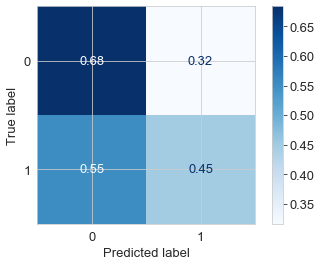

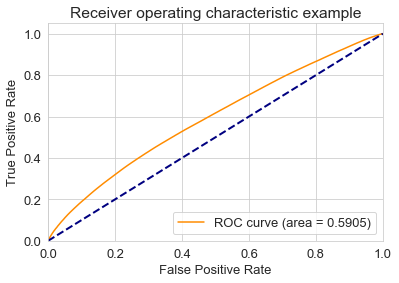

In [21]:
# Base Line Evaluation

#Building the Logistic Regression Model
lr = LogisticRegression(max_iter = 4000)

lr.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = lr.predict_proba(X_test)[:,1]
y_train_proba = lr.predict_proba(X_train)[:,1]

y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %lr.score(X_train, y_train))
print("Test accuracy    : %0.4f" %lr.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(lr, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


In [22]:
X_train.shape

(5164192, 65)

### Support Vector Machines

Training accuracy: 0.6404
Test accuracy    : 0.6412
Training AUC Score: 0.6820
Testing AUC Score: 0.6825
Classification Report - Training
              precision    recall  f1-score   support

           0       0.65      0.61      0.63   2564524
           1       0.63      0.67      0.65   2599668

    accuracy                           0.64   5164192
   macro avg       0.64      0.64      0.64   5164192
weighted avg       0.64      0.64      0.64   5164192

Classification Report - Testing
              precision    recall  f1-score   support

           0       0.65      0.61      0.63   1098238
           1       0.64      0.67      0.65   1114988

    accuracy                           0.64   2213226
   macro avg       0.64      0.64      0.64   2213226
weighted avg       0.64      0.64      0.64   2213226



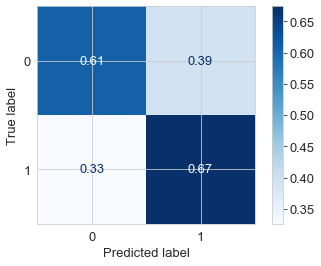

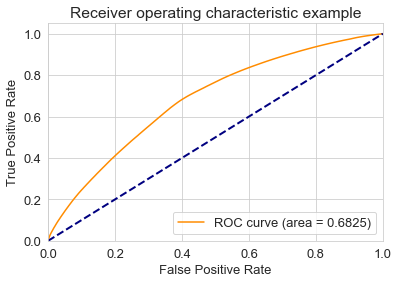

In [23]:
from sklearn.svm import LinearSVC

svm = LinearSVC(dual = False)#, class_weight = 'balanced')

svm.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = svm.decision_function(X_test)
y_train_proba = svm.decision_function(X_train)


y_pred_test = svm.predict(X_test)
y_pred_train = svm.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %svm.score(X_train, y_train))
print("Test accuracy    : %0.4f" %svm.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(svm, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)

### Decision Tree

Training accuracy: 0.6461
Test accuracy    : 0.6464
Training AUC Score: 0.6892
Testing AUC Score: 0.6896
Classification Report - Training
              precision    recall  f1-score   support

           0       0.64      0.65      0.65   2564524
           1       0.65      0.64      0.65   2599668

    accuracy                           0.65   5164192
   macro avg       0.65      0.65      0.65   5164192
weighted avg       0.65      0.65      0.65   5164192

Classification Report - Testing
              precision    recall  f1-score   support

           0       0.64      0.65      0.65   1098238
           1       0.65      0.64      0.65   1114988

    accuracy                           0.65   2213226
   macro avg       0.65      0.65      0.65   2213226
weighted avg       0.65      0.65      0.65   2213226



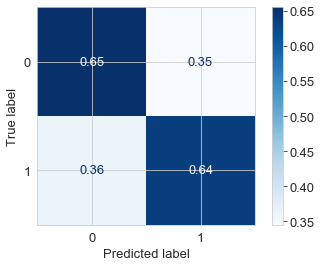

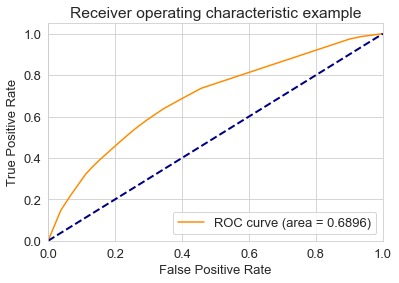

In [24]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier


dtree = DecisionTreeClassifier(random_state = 42, max_depth = 5)

dtree.fit(X_train, y_train)
#figsize(40,40)
#_ = plot_tree(dtree.fit(X_train, y_train), feature_names = X_train.columns,class_names = class_names,
#             filled = True, proportion = True, rounded = True, fontsize=14) 

#Predicting for testing and trainig data sets
y_test_proba = dtree.predict_proba(X_test)[:,1]
y_train_proba = dtree.predict_proba(X_train)[:,1]

y_pred_test = dtree.predict(X_test)
y_pred_train = dtree.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %dtree.score(X_train, y_train))
print("Test accuracy    : %0.4f" %dtree.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(dtree, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 20 Feature Importance


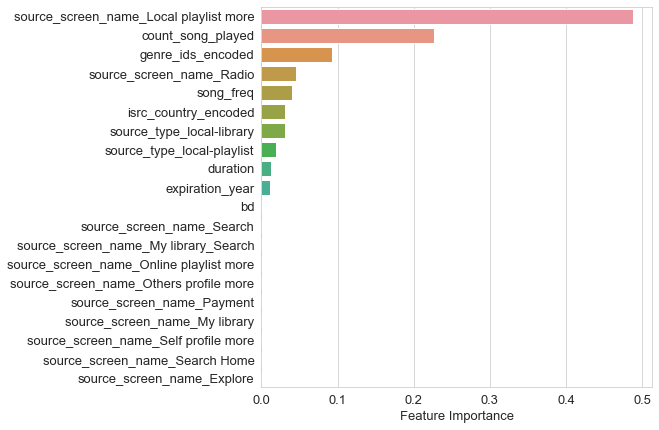

In [25]:
figsize(7,7)
import seaborn as sns
coefficients = dtree.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 20 Feature Importance")
_ = sns.barplot(data = coef[:20], x = 'Feature Importance', y = coef[:20].index, orient = 'h')

### XGBoost

In [20]:
import xgboost as xgb
# Base Line Evaluation
xg = xgb.XGBClassifier(n_jobs = 2, verbose = 3)
xg.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = xg.predict_proba(X_test)[:,1]
y_train_proba = xg.predict_proba(X_train)[:,1]

y_pred_test = xg.predict(X_test)
y_pred_train = xg.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %xg.score(X_train, y_train))
print("Test accuracy    : %0.4f" %xg.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.9f' %auc_train)  
print('Testing AUC Score: %0.9f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(xg, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)

[14:07:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


MemoryError: 

In [21]:
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

Test accuracy    : 0.6690


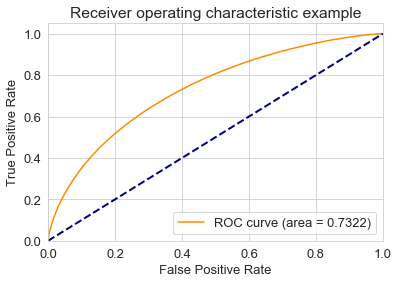

In [23]:
print("Test accuracy    : %0.4f" %xg.score(X_test, y_test))

auc_curve(y_test,y_test_proba,auc_test)

In [26]:
from sklearn.ensemble import AdaBoostClassifier

aboost = AdaBoostClassifier(random_state=42, n_estimators = 100)

aboost.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = aboost.predict_proba(X_test)[:,1]
y_train_proba = aboost.predict_proba(X_train)[:,1]

y_pred_test = aboost.predict(X_test)
y_pred_train = aboost.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %aboost.score(X_train, y_train))
print("Test accuracy    : %0.4f" %aboost.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(aboost, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


MemoryError: 

### Gradient Boosting 

Training accuracy: 0.6541
Test accuracy    : 0.6544
Training AUC Score: 0.7114
Testing AUC Score: 0.7117
Classification Report - Training
              precision    recall  f1-score   support

           0       0.66      0.64      0.65   2564524
           1       0.65      0.67      0.66   2599668

    accuracy                           0.65   5164192
   macro avg       0.65      0.65      0.65   5164192
weighted avg       0.65      0.65      0.65   5164192

Classification Report - Testing
              precision    recall  f1-score   support

           0       0.66      0.64      0.65   1098238
           1       0.65      0.67      0.66   1114988

    accuracy                           0.65   2213226
   macro avg       0.65      0.65      0.65   2213226
weighted avg       0.65      0.65      0.65   2213226



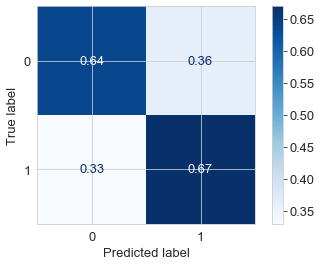

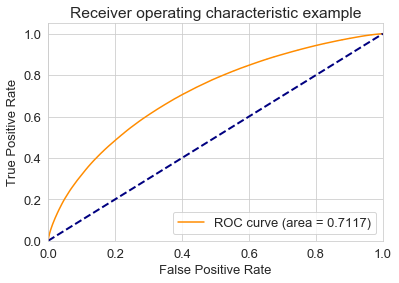

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier()

gboost.fit(X_train, y_train)

#Predicting for testing and trainig data sets
y_test_proba = gboost.predict_proba(X_test)[:,1]
y_train_proba = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_pred_train = gboost.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %gboost.score(X_train, y_train))
print("Test accuracy    : %0.4f" %gboost.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(gboost, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


### Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.7min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 16.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   38.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   37.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Paral

Training accuracy: 0.6721


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.4s finished


Test accuracy    : 0.6639
Training AUC Score: 0.7363
Testing AUC Score: 0.7250
Classification Report - Training
              precision    recall  f1-score   support

           0       0.67      0.67      0.67   2564524
           1       0.67      0.68      0.67   2599668

    accuracy                           0.67   5164192
   macro avg       0.67      0.67      0.67   5164192
weighted avg       0.67      0.67      0.67   5164192

Classification Report - Testing
              precision    recall  f1-score   support

           0       0.66      0.66      0.66   1098238
           1       0.67      0.67      0.67   1114988

    accuracy                           0.66   2213226
   macro avg       0.66      0.66      0.66   2213226
weighted avg       0.66      0.66      0.66   2213226



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.7s finished


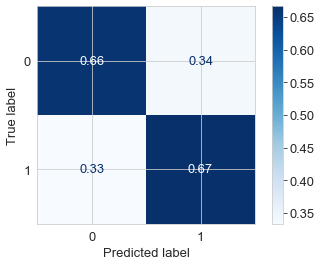

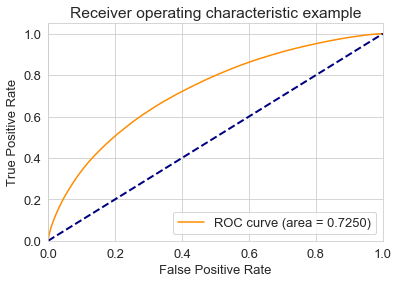

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 15, n_jobs = 4, verbose = 2)

rf.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = rf.predict_proba(X_test)[:,1]
y_train_proba = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %rf.score(X_train, y_train))
print("Test accuracy    : %0.4f" %rf.score(X_test, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(rf, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 20 Feature Importance


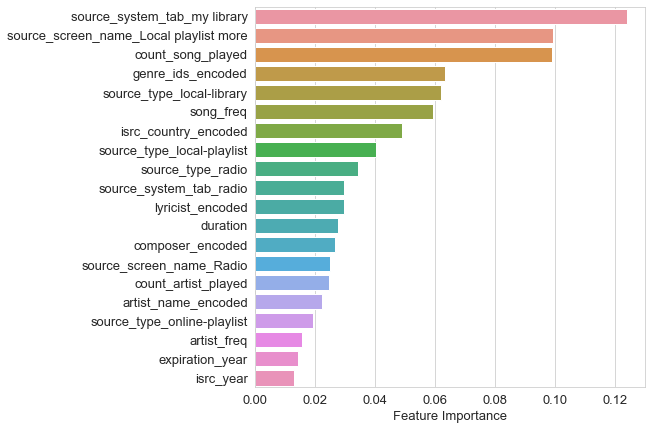

In [21]:
figsize(7,7)
coefficients = rf.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 20 Feature Importance")
_ = sns.barplot(data = coef[:20], x = 'Feature Importance', y = coef[:20].index, orient = 'h')